<a href="https://colab.research.google.com/github/MKR-24/F1-Race-Prediction/blob/main/F1_Race_Prediction_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install fastf1
import fastf1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


In [5]:
import os
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")

In [6]:
session_2024 = fastf1.get_session(2024, 3, "R")
session_2024.load()



core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:57:37.891' in Ergastresponse.
req            INFO 	No cached data found for session_status_

In [7]:
laps_2024 = session_2024.laps[["Driver", "LapTime"]].copy()
laps_2024.dropna(subset=["LapTime"], inplace=True)
laps_2024["LapTime (s)"] = laps_2024["LapTime"].dt.total_seconds()


In [8]:
avg_laps = laps_2024.groupby("Driver")["LapTime (s)"].mean().reset_index()

In [9]:
qualifying_2025 = pd.DataFrame({
    "Driver": ["Lando Norris", "Oscar Piastri", "Max Verstappen", "George Russell", "Yuki Tsunoda",
               "Alexander Albon", "Charles Leclerc", "Lewis Hamilton", "Pierre Gasly", "Carlos Sainz", "Fernando Alonso", "Lance Stroll"],
    "QualifyingTime (s)": [75.096, 75.180, 75.481, 75.546, 75.670,
                           75.737, 75.755, 75.973, 75.980, 76.062, 76.4, 76.5]
})

In [10]:
driver_mapping = {
    "Lando Norris": "NOR", "Oscar Piastri": "PIA", "Max Verstappen": "VER", "George Russell": "RUS",
    "Yuki Tsunoda": "TSU", "Alexander Albon": "ALB", "Charles Leclerc": "LEC", "Lewis Hamilton": "HAM",
    "Pierre Gasly": "GAS", "Carlos Sainz": "SAI", "Lance Stroll": "STR", "Fernando Alonso": "ALO"
}
qualifying_2025["DriverCode"] = qualifying_2025["Driver"].map(driver_mapping)

# Merge average lap time
merged_data = qualifying_2025.merge(avg_laps, left_on="DriverCode", right_on="Driver")


In [12]:
weather = session_2024.weather_data
avg_weather = weather[["AirTemp", "Humidity", "TrackTemp", "Rainfall"]].mean()
for col in avg_weather.index:
    merged_data[col] = avg_weather[col]

In [13]:
features = ["QualifyingTime (s)", "AirTemp", "Humidity", "TrackTemp", "Rainfall"]
X = merged_data[features]
y = merged_data["LapTime (s)"]


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=39)


In [16]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(X_train, y_train, epochs=150, batch_size=4, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
qualifying_features = qualifying_2025[["QualifyingTime (s)"]].copy()
for col in avg_weather.index:
    qualifying_features[col] = avg_weather[col]
qualifying_features_scaled = scaler.transform(qualifying_features)
qualifying_2025["PredictedRaceTime (s)"] = model.predict(qualifying_features_scaled).flatten()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [18]:
qualifying_2025 = qualifying_2025.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
qualifying_2025["Rank"] = qualifying_2025.index + 1

In [19]:
print("\n🏁 Predicted 2025 Chinese GP Race Rankings 🏁\n")
print(qualifying_2025[["Rank", "Driver", "PredictedRaceTime (s)"]].to_string(index=False))



🏁 Predicted 2025 Chinese GP Race Rankings 🏁

 Rank          Driver  PredictedRaceTime (s)
    1  Max Verstappen              82.988358
    2  George Russell              83.022507
    3    Yuki Tsunoda              83.087646
    4 Alexander Albon              83.122841
    5 Charles Leclerc              83.132301
    6  Lewis Hamilton              83.246826
    7    Pierre Gasly              83.250504
    8    Carlos Sainz              83.293564
    9   Oscar Piastri              84.769974
   10 Fernando Alonso              84.839920
   11    Lando Norris              86.654358
   12    Lance Stroll              87.203461


In [20]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n🔍 Model Error (MAE): {mae:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

🔍 Model Error (MAE): 1.61 seconds


<ipython-input-21-611c4bd3805d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=qualifying_2025, y="Driver", x="PredictedRaceTime (s)", palette="mako")
<ipython-input-21-611c4bd3805d>:5: UserWarning: Glyph 127950 (\N{RACING CAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127950 (\N{RACING CAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


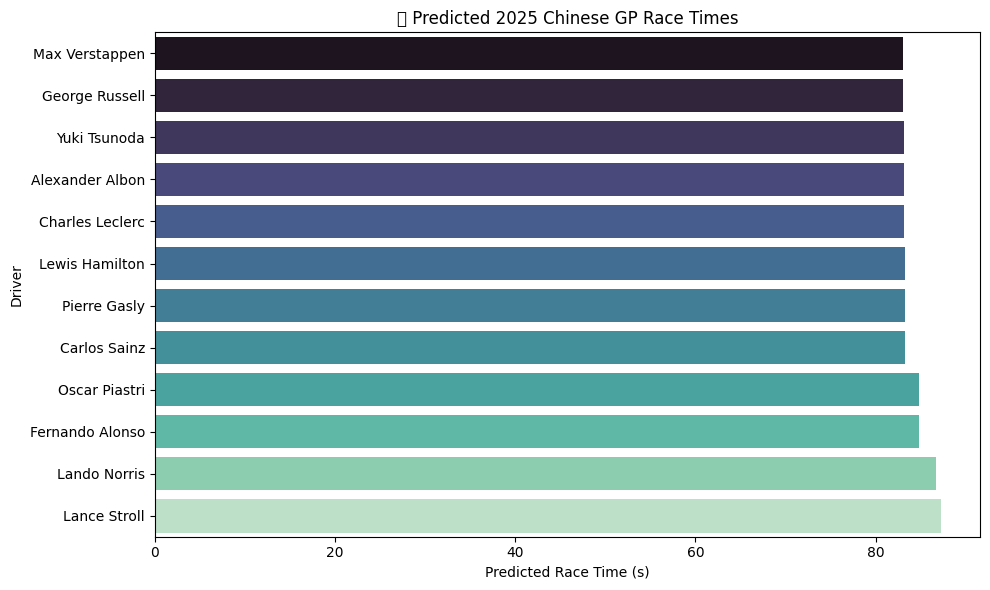

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=qualifying_2025, y="Driver", x="PredictedRaceTime (s)", palette="mako")
plt.title("🏎️ Predicted 2025 Chinese GP Race Times")
plt.xlabel("Predicted Race Time (s)")
plt.tight_layout()
plt.show()

<ipython-input-27-b2ad762250cf>:10: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


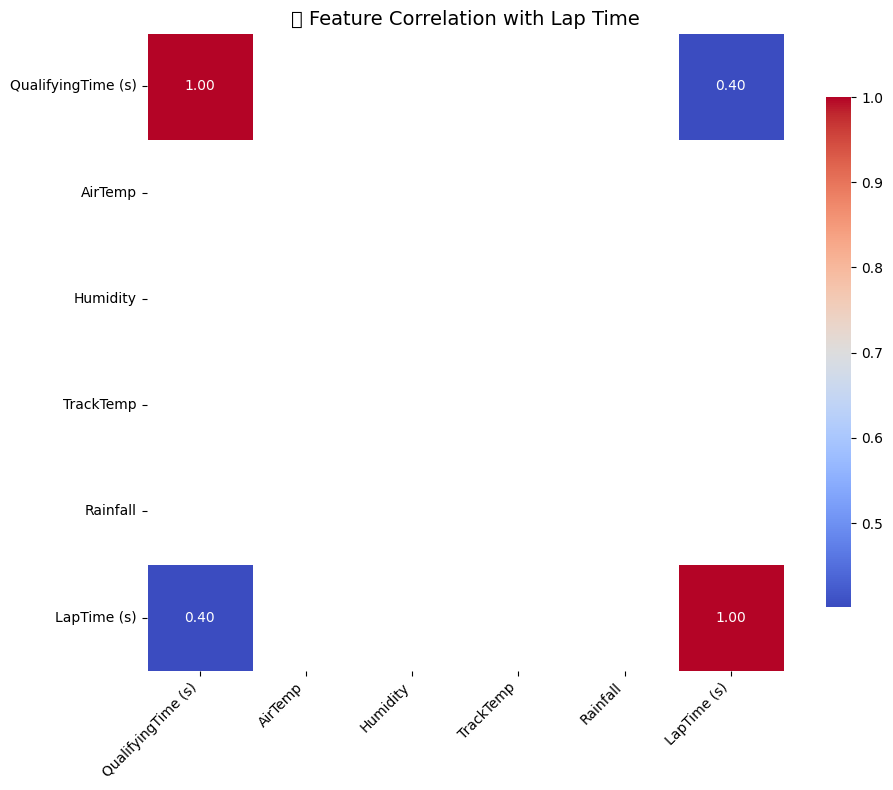

In [27]:
features = ["QualifyingTime (s)", "AirTemp", "Humidity", "TrackTemp", "Rainfall"]
corr = merged_data[features + ["LapTime (s)"]].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))  # Bigger size to fit labels
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("🔗 Feature Correlation with Lap Time", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
print(merged_data[features + ["LapTime (s)"]].dtypes)
print(merged_data[features + ["LapTime (s)"]].isnull().sum())


QualifyingTime (s)    float64
AirTemp               float64
Humidity              float64
TrackTemp             float64
Rainfall              float64
LapTime (s)           float64
dtype: object
QualifyingTime (s)    0
AirTemp               0
Humidity              0
TrackTemp             0
Rainfall              0
LapTime (s)           0
dtype: int64
